In [2]:
import twixtools
from pygrappa import grappa

import numpy as np
import matplotlib.pyplot as plt
import os

example_dir = '../example_data'

def ifftnd(kspace, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, ifftn
    if axes is None:
        axes = range(kspace.ndim)
    img = fftshift(ifftn(ifftshift(kspace, axes=axes), axes=axes), axes=axes)
    img *= np.sqrt(np.prod(np.take(img.shape, axes)))
    return img


def fftnd(img, axes=[-1]):
    from numpy.fft import fftshift, ifftshift, fftn
    if axes is None:
        axes = range(img.ndim)
    kspace = fftshift(fftn(ifftshift(img, axes=axes), axes=axes), axes=axes)
    kspace /= np.sqrt(np.prod(np.take(kspace.shape, axes)))
    return kspace

def rms_comb(sig, axis=1):
    return np.sqrt(np.sum(abs(sig)**2, axis))

In [3]:
# parse the twix file
twix = twixtools.read_twix(os.path.join("GradientEchoPre", 'meas_MID00895_FID92050_t1_gradient_echo_tra.dat'))

twix_pre = twixtools.read_twix(os.path.join("GradientEchoPre", 'meas_MID00895_FID92050_t1_gradient_echo_tra.dat'))
twix_post = twixtools.read_twix(os.path.join("GradientEchoPre", 'meas_MID00898_FID92053_t1_gradient_echo_tra.dat'))

# twix is a list of measurements:
print('\nnumber of separate scans (multi-raid):', len(twix))

Software version: VD/VE (!?)

Scan  0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7.03M/7.03M [00:00<00:00, 434MB/s]


number of separate scans (multi-raid): 1


In [4]:
# access the protocol example: print the TR of the sequence
print('\nTR = %d ms\n'%(twix[-1]['hdr']['Phoenix']['alTR'][0]/1000))


TR = 250 ms



In [5]:
# list the mdh flags and line counters for every 8th measurement data block (mdb)
for mdb in twix[-1]['mdb'][::8]:
    print('line: %3d; flags:'%(mdb.cLin), mdb.get_active_flags())

line:   0; flags: ['ONLINE', 'NOISEADJSCAN']
line:   0; flags: ['ONLINE', 'FIRSTSCANINSLICE']
line:   2; flags: ['ONLINE']
line:   4; flags: ['ONLINE']
line:   6; flags: ['ONLINE']
line:   6; flags: ['ONLINE']
line:   8; flags: ['ONLINE']
line:  10; flags: ['ONLINE']
line:  12; flags: ['ONLINE']
line:  14; flags: ['ONLINE']
line:  14; flags: ['ONLINE']
line:  16; flags: ['ONLINE']
line:  18; flags: ['ONLINE']
line:  20; flags: ['ONLINE', 'PATREFSCAN', 'PATREFANDIMASCAN']
line:  21; flags: ['ONLINE', 'PATREFSCAN']
line:  21; flags: ['ONLINE', 'PATREFSCAN']
line:  22; flags: ['ONLINE', 'PATREFSCAN', 'PATREFANDIMASCAN']
line:  23; flags: ['ONLINE', 'PATREFSCAN']
line:  24; flags: ['ONLINE', 'PATREFSCAN', 'PATREFANDIMASCAN']
line:  25; flags: ['ONLINE', 'PATREFSCAN']
line:  25; flags: ['ONLINE', 'PATREFSCAN']
line:  26; flags: ['ONLINE', 'PATREFSCAN', 'PATREFANDIMASCAN']
line:  27; flags: ['ONLINE', 'PATREFSCAN']
line:  28; flags: ['ONLINE', 'PATREFSCAN', 'PATREFANDIMASCAN']
line:  29; fla

(4, 512)

k-space shape (63, 4, 512)
(63, 512) (63, 4, 512)


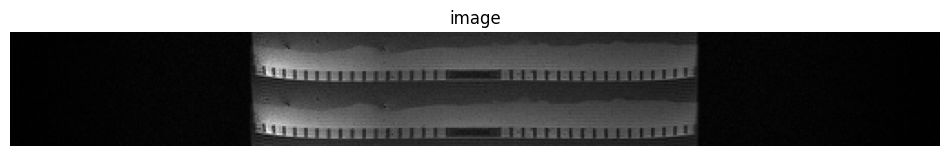

In [37]:
# sort all 'imaging' mdbs into a k-space array
image_mdbs = [mdb for mdb in twix[-1]['mdb'] if mdb.is_image_scan()]

n_line = 1 + max([mdb.cLin for mdb in image_mdbs])

# assume that all data were acquired with same number of channels & columns:
n_channel, n_column = image_mdbs[0].data.shape
print(image_mdbs[0].data.shape)

kspace = np.zeros([n_line, n_channel, n_column], dtype=np.complex64)
for mdb in image_mdbs:
    kspace[mdb.cLin] = mdb.data

print('\nk-space shape', kspace.shape)

# reconstruct an image and show the result:
plt.figure(figsize=[12,8])
#plt.subplot(121)
# plt.title('k-space')
# plt.imshow(abs(kspace[:,0])**0.2, cmap='gray', origin='lower')
# plt.axis('off')


image = ifftnd(kspace, [0,-1])
image = rms_comb(image)
print(image.shape, kspace.shape)
#plt.subplot(122)
plt.title('image')
plt.imshow(abs(image), cmap='gray', origin='lower')
plt.axis('off')
plt.show()

dict_keys(['noise', 'image', 'refscan', 'hdr', 'hdr_str'])
Cal:  (1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 1, 44, 4, 512)
['Sli', 'Lin', 'Cha', 'Col']
(10, 63, 4, 512)
Data shape at slice:  (63, 4, 512)
(63, 4, 512)
(22, 4, 512)
63 512 22 512 4
P took 0.157708 seconds!
A took 0.00138092 seconds
Training and application of weights took 0.129617seconds


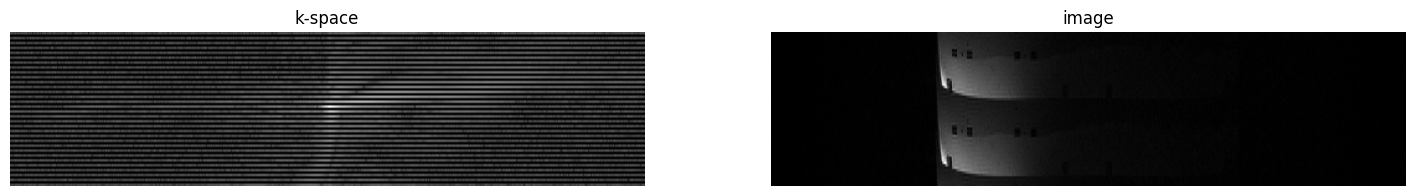

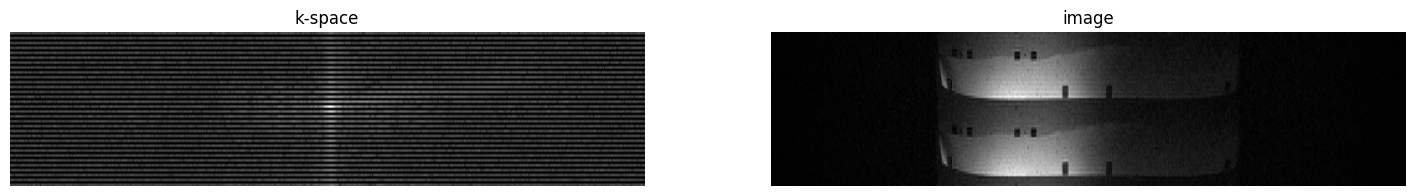

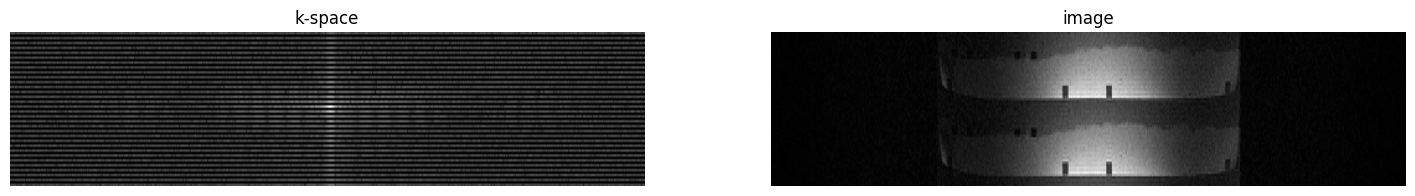

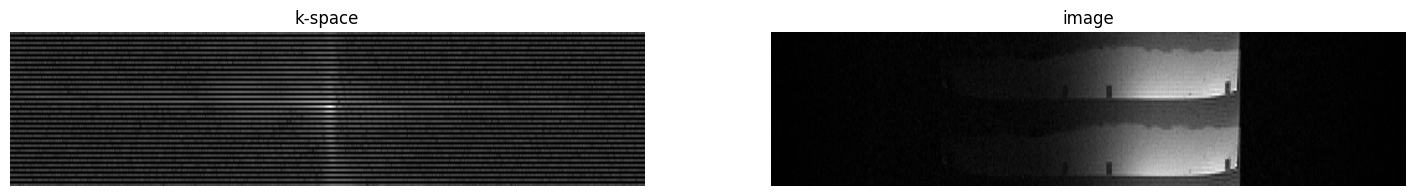

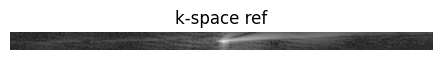

In [73]:
# map the twix data to twix_array objects
mapped = twixtools.map_twix(twix)
print(mapped[-1].keys())
im_data = mapped[-1]['image']
cal_data = mapped[-1]['refscan']
print("Cal: ", cal_data.shape)

# make sure that we later squeeze the right dimensions:
print(im_data.non_singleton_dims)

# the twix_array object makes it easy to remove the 2x oversampling in read direction
im_data.flags['remove_os'] = False

# read the data (array-slicing is also supported)
data = im_data[:].squeeze()
print(data.shape)
data = data[5,:,:,:]
print("Data shape at slice: ", data.shape)

data_cal = cal_data[:].squeeze()
data_cal = data_cal[5,22:46,:,:]

for channel in range(4):

    plt.figure(figsize=[18,2])
    plt.subplot(121)
    plt.title('k-space')
    plt.imshow(abs(data[:,channel,:])**0.2, cmap='gray', origin='lower', aspect='auto')
    plt.axis('off')

    image = ifftnd(data[:,channel,:], [0, -1])
    #image = rms_comb(img_final)
    plt.subplot(122)
    plt.title('image')
    plt.imshow(abs(image), cmap='gray', origin='lower', aspect='auto')
    plt.axis('off')


plt.figure(figsize=[12,8])
plt.subplot(121)
plt.title('k-space ref')
plt.imshow(abs(data_cal[:,0,:])**0.2, cmap='gray', origin='lower')
plt.axis('off')





print(data.shape)
print(data_cal.shape)

sx, ncoils, sy = data.shape[:]
cx, ncoils, cy = data_cal.shape[:]

print(sx, sy, cx, cy, ncoils)

res = grappa(data, data_cal, coil_axis=1, silent=False)

In [63]:
# Now do it all again for pre/post and abbreviate code 

(63, 512)
[512  63]
(63, 512)
(63, 512)


3.141566622379885


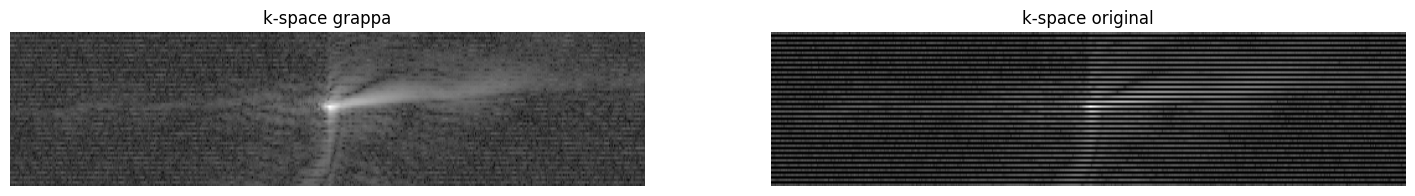

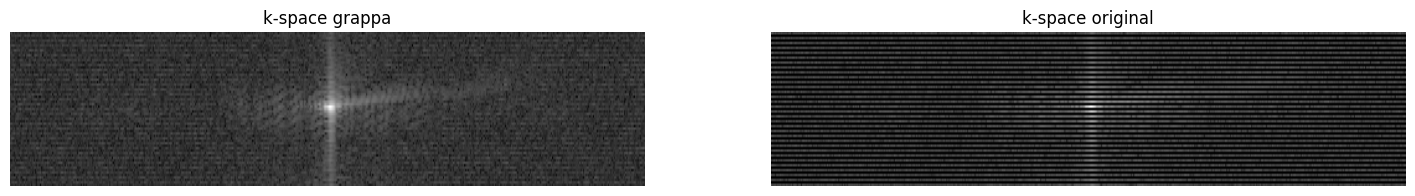

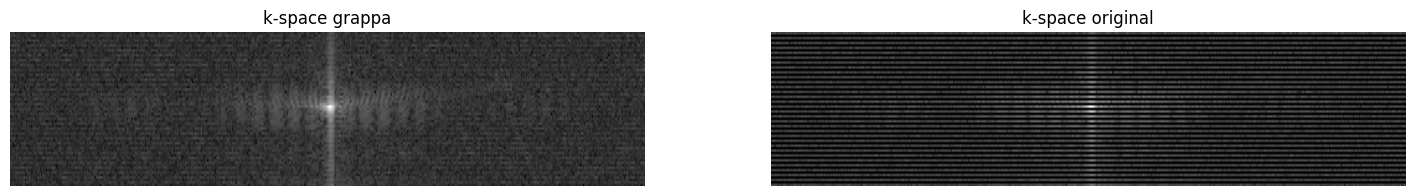

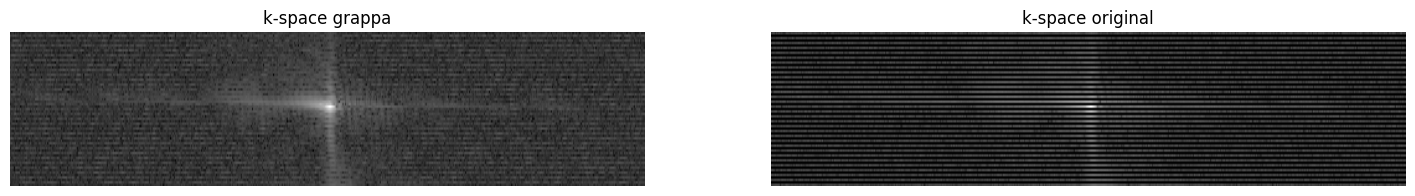

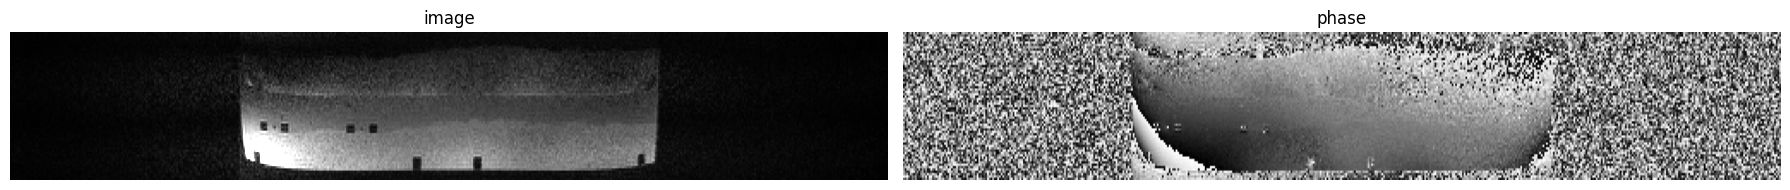

In [113]:
for channel in range(4):

    plt.figure(figsize=[18,2])
    plt.subplot(121)
    plt.title('k-space grappa')
    plt.imshow(abs(res[:,channel,:])**0.2, cmap='gray', origin='lower', aspect='auto')
    plt.axis('off')

    plt.subplot(122)
    plt.title('k-space original')
    plt.imshow(abs(data[:,channel,:])**0.2, cmap='gray', origin='lower', aspect='auto')
    plt.axis('off')

plt.figure(figsize=[18,2])
image = ifftnd(res, [0,-1])
image_rms = rms_comb(image)
plt.subplot(121)
plt.title('image')
plt.imshow(abs(image_rms), cmap='gray', origin='lower', aspect='auto',vmin=0,vmax = 0.0009)
plt.axis('off')

phase_img = np.angle(image)
phase_img_rms = rms_comb(phase_img)
plt.subplot(122)
plt.title('phase')
plt.imshow(phase_img[:,0,:], cmap='gray', origin='lower', aspect='auto')
plt.axis('off')
    
plt.tight_layout()

print(np.max(phase_img))

In [ ]:
# Now make phase map for pre/post



In [106]:
twix = twixtools.read_twix(os.path.join("GradientEchoPre", 'meas_MID00895_FID92050_t1_gradient_echo_tra.dat'), keep_syncdata_and_acqend=True)
mapped = twixtools.map_twix(twix[-1])

         Setting keep_syncdata and keep_acqend to {True}.
Software version: VD/VE (!?)

Scan  0


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7.03M/7.03M [00:00<00:00, 486MB/s]


In [107]:
data = mapped['image'][0,0,0,0,0,0,0,0].squeeze()
print(data.shape)

(10, 63, 4, 512)
